In [1]:
import tensorflow as tf
import librosa
import pandas as pd
import os
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
from scipy.io.wavfile import write
import glob
import numpy as np
#from playsound import playsound as ps
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile

def PathFinder():
    FileTypes = ['wav']
    SearchStrings = ['sp']
    cleanpath_list = []
    noisypath_list = []
    top = os.getcwd()
    print(top)
    filecount = 0

    for root, dirs, files in os.walk(top, topdown=False):
        for fl in files:
            currentFile = os.path.join(root, fl)
            for FileType in FileTypes:
                status = str.endswith(currentFile, FileType)
                if str(status) == 'True':
                    for SearchString in SearchStrings:
                        if str(SearchString in currentFile) == 'True':
                            if str(currentFile) not in cleanpath_list:
                                if re.search("Clean", currentFile):
                                    filecount = filecount + 1
                                    cleanpath_list.append(currentFile)
                            if str(currentFile) not in noisypath_list:
                                if re.search("Noisy", currentFile):
                                    filecount = filecount + 1
                                    noisypath_list.append(currentFile)

    return cleanpath_list, noisypath_list

cleanl, noisyl = PathFinder()

C:\Users\TruMoone\PycharmProjects\Audio_Denoiser


In [2]:
model = tf.keras.models.load_model('C:/Users/TruMoone/PycharmProjects/CNNModel/Denoiser_ver1.h5')

path_to_dataset = "C:/Users/TruMoone/PycharmProjects/Records"
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))

windowLength = 256
overlap = round(0.25 * windowLength)  # overlap of 75%
ffTLength = windowLength
inputFs = 48e3
fs = 16e3
numFeatures = ffTLength // 2 + 1
numSegments = 8
print("windowLength:", windowLength)
print("overlap:", overlap)
print("ffTLength:", ffTLength)
print("inputFs:", inputFs)
print("fs:", fs)
print("numFeatures:", numFeatures)
print("numSegments:", numSegments)
# %%
mozilla_basepath = 'C:\\Users\\TruMoone\\PycharmProjects\\CommonVoice\\Datasets\\en\\'
UrbanSound8K_basepath = 'C:\\Users\\TruMoone\\PycharmProjects\\UrbanSound8K\\audio\\'


def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr


def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio


def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV fileF


# %%
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                              n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length,
                                                    hop_length=self.overlap,
                                                    win_length=self.window_length, window=self.window,
                                                    center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)



cleanAudio, sr = read_audio(cleanl[5], sample_rate=fs)
print("Min:", np.min(cleanAudio), "Max:", np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr, autoplay=False)  # load a local WAV file\n",

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8
Min: -0.25108454 Max: 0.33333334


Min: -0.3333333 Max: 0.28136697


Min: 9.136192e-08 Max: 6.6967545


In [5]:
# %%
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments

def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

# %%
pattern = re.compile(r'[\w-]+\.')
cn = 0
for audiopth in noisyl:
    noisyAudio, sr = read_audio(audiopth, sample_rate=fs)
    #noisyAudio =ipd.Audio(data=audiopth, rate=fs, autoplay=False)
    
    noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
    noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

    # Paper: Besides, spectral phase was not used in the training phase.
    # At reconstruction, noisy spectral phase was used instead to
    # perform in- verse STFT and recover human speech.
    noisyPhase = np.angle(noise_stft_features)
    print(noisyPhase.shape)
    noise_stft_features = np.abs(noise_stft_features)

    mean = np.mean(noise_stft_features)
    std = np.std(noise_stft_features)
    noise_stft_features = (noise_stft_features - mean) / std
    # %%
    predictors = prepare_input_features(noise_stft_features)
    # %%
    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    print('predictors.shape:', predictors.shape)
    # %%
    STFTFullyConvolutional = model.predict(predictors)
    print(STFTFullyConvolutional.shape)


    # %%
    denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
    print("Min:", np.min(denoisedAudioFullyConvolutional), "Max:", np.max(denoisedAudioFullyConvolutional))
    ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs, autoplay=False)  # load a local WAV file
    #denoisedAudioFullyConvolutional.export('C:/Users/TruMoone/PycharmProjects/Evaluation/denoised_audio.mp3', format="mp3", bitrate="64k")
    write('C:/Users/TruMoone/PycharmProjects/Evaluation/noisy'+str(cn)+'.wav', 16000, denoisedAudioFullyConvolutional)
    cn += 1

(129, 660)
predictors.shape: (660, 129, 8, 1)
(660, 129, 1, 1)
Min: -0.20550898 Max: 0.21058646
(129, 629)
predictors.shape: (629, 129, 8, 1)
(629, 129, 1, 1)
Min: -0.1324564 Max: 0.18216775
(129, 687)
predictors.shape: (687, 129, 8, 1)
(687, 129, 1, 1)
Min: -0.24350166 Max: 0.20464794
(129, 571)
predictors.shape: (571, 129, 8, 1)
(571, 129, 1, 1)
Min: -0.1833959 Max: 0.2223309
(129, 878)
predictors.shape: (878, 129, 8, 1)
(878, 129, 1, 1)
Min: -0.16101119 Max: 0.23037922
(129, 635)
predictors.shape: (635, 129, 8, 1)
(635, 129, 1, 1)
Min: -0.18787138 Max: 0.22904907


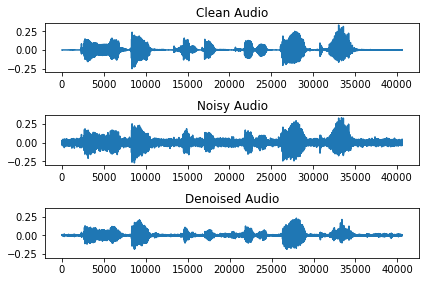

In [6]:
    # %%
    # A numeric identifier of the sound class -- Types of noise
    # 0 = air_conditioner
    # 1 = car_horn
    # 2 = children_playing
    # 3 = dog_bark
    # 4 = drilling
    # 5 = engine_idling
    # 6 = gun_shot
    # 7 = jackhammer
    # 8 = siren
    # 9 = street_music

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

    ax1.plot(cleanAudio)
    ax1.set_title("Clean Audio")

    ax2.plot(noisyAudio)
    ax2.set_title("Noisy Audio")

    ax3.plot(denoisedAudioFullyConvolutional)
    ax3.set_title("Denoised Audio")

    f.tight_layout(pad=1.0)